<a href="https://colab.research.google.com/github/plthiyagu/AI-Engineering/blob/master/01-Machine%20Learning/Credit_Worthiness_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap

In [3]:
### Necessary imports
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import fbeta_score

import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
import shap

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
filepath='https://raw.githubusercontent.com/plthiyagu/Personnel/master/Dataset/german_credit.csv'
df_credit= pd.read_csv(filepath)

In [5]:
y = df_credit['Risk']
X = df_credit.drop(columns = ['Risk'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1)

df_train = pd.concat([X_train, y_train], axis = 1)
df_test = pd.concat([X_test, y_test], axis = 1)

print(df_train.shape, df_test.shape)

(900, 10) (100, 10)


In [6]:
df_train.head()

,Credit History,Age,Gender,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,Risk
900,4,43,male,2,rent,little,2625,16,car,bad
326,4,49,male,2,rent,NaN,5801,12,furniture/equipment,good
913,2,28,male,2,own,rich,2142,11,business,good
868,2,37,male,2,own,NaN,7409,36,business,good
580,4,30,male,2,own,little,1056,18,car,bad


Train and Test Distribution comparison



Text(0.5, 0, 'Credit History')

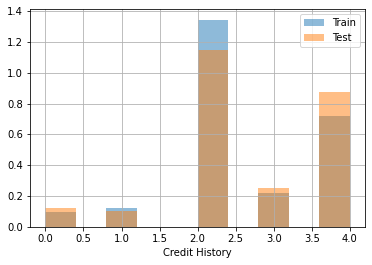

In [7]:
df_train.loc[:, 'Credit History'].hist(alpha=0.5, label='Train', density=True)    
df_test.loc[:, 'Credit History'].hist(alpha=0.5, label='Test', density=True)
plt.xlabel('Credit History')
plt.legend()


Text(0.5, 0, 'Age')

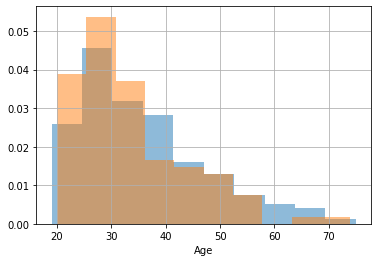

In [8]:
df_train.loc[:, 'Age'].hist(alpha=0.5, label='Train', density=True)    
df_test.loc[:, 'Age'].hist(alpha=0.5, label='Test', density=True)  
plt.xlabel('Age')

Text(0.5, 0, 'Job')

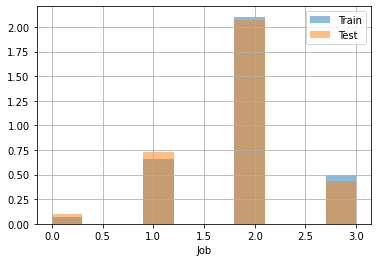

In [9]:
df_train.loc[:, 'Job'].hist(alpha=0.5, label='Train', density=True)    
df_test.loc[:, 'Job'].hist(alpha=0.5, label='Test', density=True)
plt.xlabel('Job')
plt.legend()

Text(0.5, 0, 'Duration')

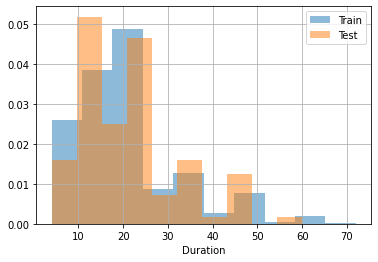

In [10]:
df_train.loc[:, 'Duration'].hist(alpha=0.5, label='Train', density=True)    
df_test.loc[:, 'Duration'].hist(alpha=0.5, label='Test', density=True)
plt.xlabel('Duration')
plt.legend()

Text(0.5, 0, 'Credit amount')

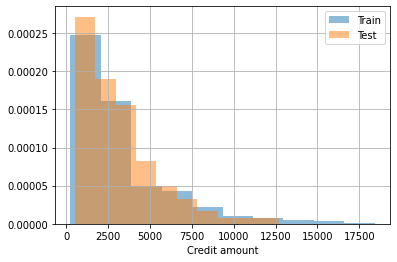

In [11]:
df_train.loc[:, 'Credit amount'].hist(alpha=0.5, label='Train', density=True)    
df_test.loc[:, 'Credit amount'].hist(alpha=0.5, label='Test', density=True)
plt.xlabel('Credit amount')
plt.legend()

Text(0.5, 0, 'Saving accounts')

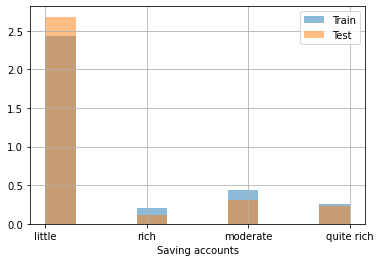

In [12]:
df_train.loc[:, 'Saving accounts'].hist(alpha=0.5, label='Train', density=True)    
df_test.loc[:, 'Saving accounts'].hist(alpha=0.5, label='Test', density=True)
plt.xlabel('Saving accounts')
plt.legend()

In [14]:
from scipy.stats import ks_2samp
ks_2samp(df_train['Duration'], df_test['Duration'])

Ks_2sampResult(statistic=0.06666666666666667, pvalue=0.7989499641283465)

In [15]:
ks_2samp(df_train['Age'], df_test['Age'])

Ks_2sampResult(statistic=0.10777777777777778, pvalue=0.23308782418433838)

Preliminary data analysis

In [16]:
df_train.head()

,Credit History,Age,Gender,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,Risk
900,4,43,male,2,rent,little,2625,16,car,bad
326,4,49,male,2,rent,NaN,5801,12,furniture/equipment,good
913,2,28,male,2,own,rich,2142,11,business,good
868,2,37,male,2,own,NaN,7409,36,business,good
580,4,30,male,2,own,little,1056,18,car,bad


In [17]:
df_train.nunique()

Credit History       5
Age                 53
Gender               2
Job                  4
Housing              3
Saving accounts      4
Credit amount      837
Duration            32
Purpose              8
Risk                 2
dtype: int64

In [18]:
df_train.Risk.value_counts() ### Good = 1 (credit worthy), Bad = 0 (not worthy)

good    636
bad     264
Name: Risk, dtype: int64

In [19]:
df_train_summ = df_train.describe()
df_train_summ

,Credit History,Age,Job,Credit amount,Duration
count,900.000000,900.000000,900.000000,900.000000,900.000000
mean,2.532222,35.755556,1.910000,3284.276667,20.818889
std,1.075599,11.460442,0.651609,2872.686362,12.099857
min,0.000000,19.000000,0.000000,250.000000,4.000000
25%,2.000000,27.000000,2.000000,1364.000000,12.000000
50%,2.000000,33.000000,2.000000,2300.000000,18.000000
75%,4.000000,42.000000,2.000000,3959.000000,24.000000
max,4.000000,75.000000,3.000000,18424.000000,72.000000


(array([405., 263.,  82.,  70.,  36.,  17.,  13.,   8.,   5.,   1.]),
 array([  250. ,  2067.4,  3884.8,  5702.2,  7519.6,  9337. , 11154.4,
        12971.8, 14789.2, 16606.6, 18424. ]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, 'Credit amount distribution')

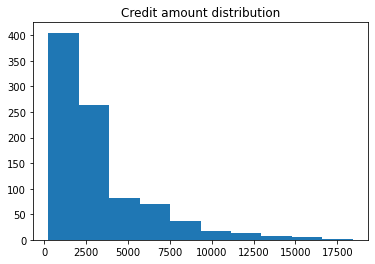

In [20]:
plt.hist(df_train['Credit amount'])
plt.title('Credit amount distribution')

In [21]:
### the credit amount is highly skewed distribution, lets analyse the extreme values beyond 3 sigma
def extreme_count(sig_factor, feat):
    sig_cutoff = df_train_summ[feat]['mean'] + sig_factor*df_train_summ[feat]['std'] 
    sig_count = len(df_train[df_train[feat] > sig_cutoff])
    print("instances of {} greater than {} sigma ({} cutoff) are {}".format(feat, sig_factor, sig_cutoff, sig_count))
    return

extreme_count(3, feat = 'Credit amount')

instances of Credit amount greater than 3 sigma (11902.335753866473 cutoff) are 22


(array([131., 230., 161., 142.,  81.,  65.,  38.,  26.,  20.,   6.]),
 array([19. , 24.6, 30.2, 35.8, 41.4, 47. , 52.6, 58.2, 63.8, 69.4, 75. ]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, 'Age distribution')

instances of Age greater than 3 sigma (70.13688245838982 cutoff) are 5


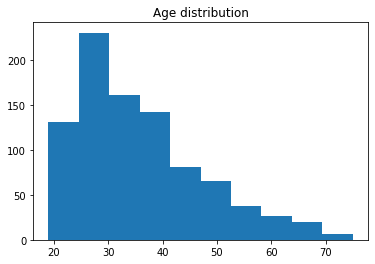

In [22]:
plt.hist(df_train['Age'])
plt.title('Age distribution')
extreme_count(3, feat = 'Age')

(array([159., 235., 298.,  53.,  77.,  16.,  47.,   2.,  12.,   1.]),
 array([ 4. , 10.8, 17.6, 24.4, 31.2, 38. , 44.8, 51.6, 58.4, 65.2, 72. ]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, 'Duration distribution')

instances of Duration greater than 3 sigma (57.11845988198104 cutoff) are 13


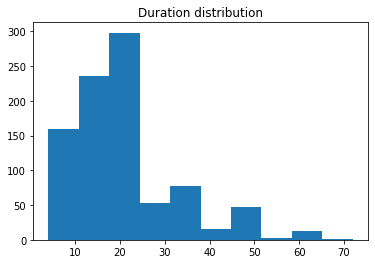

In [23]:
plt.hist(df_train['Duration'])
plt.title('Duration distribution')
extreme_count(3, feat = 'Duration')

In [24]:
''' Even if there are certain instances where the above features are beyond 3sigma of their mean value, they dont appear to be 
outliers, as its legible to have certain certain loans with high credit value, or loan duration is longer, or older population 
is seeking loan. Hence, I am not eliminating these rows'''

' Even if there are certain instances where the above features are beyond 3sigma of their mean value, they dont appear to be \noutliers, as its legible to have certain certain loans with high credit value, or loan duration is longer, or older population \nis seeking loan. Hence, I am not eliminating these rows'

Finding Missing values, checking if they are legitimate and applying apt transformation

In [25]:
df_train.isnull().sum()

Credit History       0
Age                  0
Gender               0
Job                  0
Housing              0
Saving accounts    170
Credit amount        0
Duration             0
Purpose              0
Risk                 0
dtype: int64

In [26]:
### NaN is a valid field here implying no saving account

df_train['Saving accounts'].value_counts()
df_train['Saving accounts'].unique()

### So, replacing NaN with 'no account'
df_train.loc[df_train['Saving accounts'].isnull(), 'Saving accounts'] = 'no account'

### Replaced in df
df_train['Saving accounts'].value_counts()
df_train['Saving accounts'].unique()

### No NaNs anymore
df_train.isnull().sum()

little        533
moderate       95
quite rich     57
rich           45
Name: Saving accounts, dtype: int64

array(['little', nan, 'rich', 'moderate', 'quite rich'], dtype=object)

little        533
no account    170
moderate       95
quite rich     57
rich           45
Name: Saving accounts, dtype: int64

array(['little', 'no account', 'rich', 'moderate', 'quite rich'],
      dtype=object)

Credit History     0
Age                0
Gender             0
Job                0
Housing            0
Saving accounts    0
Credit amount      0
Duration           0
Purpose            0
Risk               0
dtype: int64

Checking data types and categorical states of features for encoding

In [27]:
df_train.dtypes

Credit History      int64
Age                 int64
Gender             object
Job                 int64
Housing            object
Saving accounts    object
Credit amount       int64
Duration            int64
Purpose            object
Risk               object
dtype: object

In [28]:
df_train.nunique()

Credit History       5
Age                 53
Gender               2
Job                  4
Housing              3
Saving accounts      5
Credit amount      837
Duration            32
Purpose              8
Risk                 2
dtype: int64

Feature Selection for label and one hot encoding

In [29]:
#df_count = (pd.DataFrame(df_train.nunique(), columns=['count'])).reset_index()
#le_list = df_count[df_count['count'] == 2]['index'].values.tolist()
df_dtypes = pd.DataFrame((df_credit.dtypes == 'object'), columns = ['obj_type'])
obj_list = df_dtypes[(df_dtypes.obj_type == True)].index
#print(obj_list)
#ohe_list = list(obj_list.difference(le_list))
print("Features for label encoding:", obj_list)
#print("Features for OHE:", ohe_list)

Features for label encoding: Index(['Gender', 'Housing', 'Saving accounts', 'Purpose', 'Risk'], dtype='object')


Label Encoding

In [30]:
le_obj = LabelEncoder()
for feat in obj_list:
    df_train[feat] = le_obj.fit_transform(df_train[feat])

In [32]:
df_train

,Credit History,Age,Gender,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,Risk
900,4,43,1,2,2,0,2625,16,1,0
326,4,49,1,2,2,2,5801,12,4,1
913,2,28,1,2,1,4,2142,11,0,1
868,2,37,1,2,1,2,7409,36,0,1
580,4,30,1,2,1,0,1056,18,1,0
...,...,...,...,...,...,...,...,...,...,...
718,4,31,1,2,1,2,3148,24,5,1
727,2,25,0,2,2,0,1882,18,5,0
183,4,50,1,2,1,4,3777,24,4,1
906,2,24,1,1,1,2,3763,21,1,1


In [33]:
df_train.Risk.value_counts()

1    636
0    264
Name: Risk, dtype: int64

In [34]:
279/621

0.4492753623188406

In [35]:
df_train.corr()
### Credit amount and Duration have high correlation relatively and can be considered in feature selection step to drop 'Duration'

,Credit History,Age,Gender,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,Risk
Credit History,1.000000,0.136538,0.080412,0.022394,-0.062165,0.054310,-0.056475,-0.071302,0.039189,0.230438
Age,0.136538,1.000000,0.167529,0.028927,-0.307736,0.075580,0.029644,-0.046452,-0.050766,0.104501
Gender,0.080412,0.167529,1.000000,0.064810,-0.216433,0.004507,0.097625,0.069116,-0.039540,0.101438
Job,0.022394,0.028927,0.064810,1.000000,-0.124638,-0.024301,0.286562,0.208566,-0.033296,-0.025332
Housing,-0.062165,-0.307736,-0.216433,-0.124638,1.000000,0.019072,-0.145950,-0.149182,0.022534,-0.037741
Saving accounts,0.054310,0.075580,0.004507,-0.024301,0.019072,1.000000,-0.027649,-0.012181,-0.041830,0.196480
Credit amount,-0.056475,0.029644,0.097625,0.286562,-0.145950,-0.027649,1.000000,0.628590,-0.157396,-0.154026
Duration,-0.071302,-0.046452,0.069116,0.208566,-0.149182,-0.012181,0.628590,1.000000,-0.093293,-0.219929
Purpose,0.039189,-0.050766,-0.039540,-0.033296,0.022534,-0.041830,-0.157396,-0.093293,1.000000,0.062599
Risk,0.230438,0.104501,0.101438,-0.025332,-0.037741,0.196480,-0.154026,-0.219929,0.062599,1.000000


Ques1 : More credit history is equivalent to credit worthiness

(array([[ 21.,   0.,  25.,   0.,   0., 153.,   0.,  24.,   0.,  41.],
        [ 14.,   0.,  20.,   0.,   0., 331.,   0.,  54.,   0., 217.]]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 2 Lists of Patches objects>)

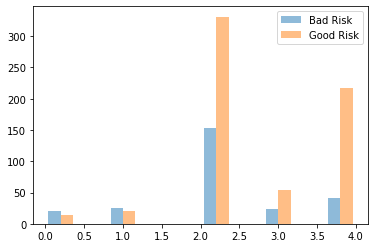

In [36]:
plt.hist([df_train.loc[df_train['Risk'] == 0, 'Credit History'].values, df_train.loc[df_train['Risk'] == 1, 'Credit History'].values], alpha=0.5, label=['Bad Risk', 'Good Risk'])
plt.legend(loc='upper right')

In [37]:
df_train[df_train['Risk'] == 0]['Credit History'].value_counts()

2    153
4     41
1     25
3     24
0     21
Name: Credit History, dtype: int64

In [38]:
df_train[df_train['Risk'] == 1]['Credit History'].value_counts()

2    331
4    217
3     54
1     20
0     14
Name: Credit History, dtype: int64

Conclusion: As the credit history increases, the good risk increases proportionately i..e credit worthiness improves sharply

Ques2 : Are young people more credit worthy? Yes



(array([[ 55.,  77.,  43.,  31.,  21.,  11.,  12.,   8.,   5.,   1.],
        [ 76., 153., 118., 111.,  60.,  54.,  26.,  18.,  15.,   5.]]),
 array([19. , 24.6, 30.2, 35.8, 41.4, 47. , 52.6, 58.2, 63.8, 69.4, 75. ]),
 <a list of 2 Lists of Patches objects>)

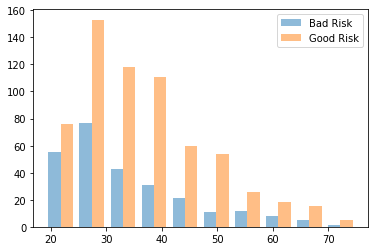

In [39]:
plt.hist([df_train.loc[df_train['Risk'] == 0, 'Age'].values, df_train.loc[df_train['Risk'] == 1, 'Age'].values], alpha=0.5, label=['Bad Risk', 'Good Risk'])
plt.legend(loc='upper right')

In [40]:
df_train.Age[df_train.Age <= 30] = 0
df_train.Age[(df_train.Age > 30) & (df_train.Age < 45)] = 1
df_train.Age[(df_train.Age >= 45)] = 2

In [41]:
df_train[df_train['Risk'] == 0]['Age'].value_counts()
df_train[df_train['Risk'] == 1]['Age'].value_counts()

0    132
1     89
2     43
Name: Age, dtype: int64

1    264
0    229
2    143
Name: Age, dtype: int64

More credit accounts equivalent to more credit worthy? Inconclusive



(array([[191.,   0.,  31.,   0.,   0.,  28.,   0.,  10.,   0.,   4.],
        [342.,   0.,  64.,   0.,   0., 142.,   0.,  47.,   0.,  41.]]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 2 Lists of Patches objects>)

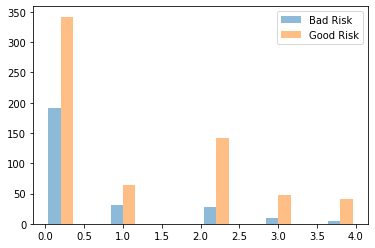

In [42]:
plt.hist([df_train.loc[df_train['Risk'] == 0, 'Saving accounts'].values, df_train.loc[df_train['Risk'] == 1, 'Saving accounts'].values], alpha=0.5, label=['Bad Risk', 'Good Risk'])
plt.legend(loc='upper right')

In [43]:
df_train[df_train['Risk'] == 0]['Saving accounts'].value_counts()
df_train[df_train['Risk'] == 1]['Saving accounts'].value_counts()

0    191
1     31
2     28
3     10
4      4
Name: Saving accounts, dtype: int64

0    342
2    142
1     64
3     47
4     41
Name: Saving accounts, dtype: int64

Modelling

X_train, y_train prep



In [44]:
y_train = df_train['Risk']
X_train = df_train.drop(columns = ['Risk'])

Test data prep



In [45]:
df_test.isnull().sum()
### So, replacing NaN with 'no account'
df_test.loc[df_test['Saving accounts'].isnull(), 'Saving accounts'] = 'no account'
df_test.isnull().sum()

Credit History      0
Age                 0
Gender              0
Job                 0
Housing             0
Saving accounts    13
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64

Credit History     0
Age                0
Gender             0
Job                0
Housing            0
Saving accounts    0
Credit amount      0
Duration           0
Purpose            0
Risk               0
dtype: int64

In [46]:
le_obj = LabelEncoder()
for feat in obj_list:
    df_test[feat] = le_obj.fit_transform(df_test[feat])


In [47]:
df_test.head()

,Credit History,Age,Gender,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,Risk
746,2,23,0,2,2,0,2511,15,1,1
826,4,33,0,2,2,0,3966,18,1,0
506,4,36,1,2,1,3,2360,15,1,1
922,2,22,0,2,2,0,1366,9,5,0
650,2,50,1,3,0,0,7476,48,3,1


In [48]:
train_cols = df_train.columns.tolist()
test_cols = df_test.columns.tolist()

In [49]:
delta_cols = list(set(train_cols).difference(test_cols))

In [50]:
delta_cols

[]

In [51]:
y_test = df_test['Risk']
X_test = df_test.drop(columns = ['Risk'])

In [52]:
import numpy as np
from sklearn.metrics import fbeta_score, make_scorer
ftwo_scorer = make_scorer(fbeta_score, beta=1/5)

In [53]:
### As it is bad to classify a customer as good when they are bad i.e. objective is to reduce FP, we want better precision 
### Hence, applying beta = 1/5 and selecting fbeta_score as evaluation metric
fbeta_mu_score, fbeta_sigma_score = [], []
model_list = [DecisionTreeClassifier(), RandomForestClassifier(), LogisticRegression()]
for model in model_list:
    obj = model
    scores = cross_val_score(obj, X_train, y_train, cv=5, scoring = ftwo_scorer)
    fbeta_mu_score.append(np.mean(scores))
    fbeta_sigma_score.append(np.std(scores))


In [54]:
fbeta_mu_score
fbeta_sigma_score

[0.7767785847867104, 0.7741690644279738, 0.7654426622285098]

[0.02955797587432625, 0.016996706656754183, 0.021309056788594273]

In [55]:
model_index = fbeta_mu_score.index(max(fbeta_mu_score))
selected_model = model_list[model_index]
selected_model

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [56]:
selected_model = RandomForestClassifier(max_depth=3, min_samples_leaf=50)
selected_model.fit(X_train, y_train)
y_pred = selected_model.predict(X_test)
fbeta_score(y_test, y_pred, beta=1/5)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

0.6489859594383776

In [57]:
df_feat = pd.DataFrame()
df_feat['cols'] = X_train.columns
if str(selected_model)[:3] == 'Log' :
    df_feat['importance'] = np.abs(selected_model.coef_[0])
else:
    df_feat['importance'] = selected_model.feature_importances_


In [58]:
top_3 = list(df_feat.sort_values(by = 'importance', ascending = False).head(3)['cols'].values)
print("top 3 features:", top_3)
print("Top 3 features' cumulative importance:", np.round(100*df_feat.sort_values(by = 'importance', ascending = False).head(3)['importance'].sum()))

top 3 features: ['Duration', 'Credit History', 'Saving accounts']
Top 3 features' cumulative importance: 71.0


In [59]:
df_test.head()

,Credit History,Age,Gender,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,Risk
746,2,23,0,2,2,0,2511,15,1,1
826,4,33,0,2,2,0,3966,18,1,0
506,4,36,1,2,1,3,2360,15,1,1
922,2,22,0,2,2,0,1366,9,5,0
650,2,50,1,3,0,0,7476,48,3,1


In [69]:
# Interpretibility
### Supply the index of specific test row

row_idx = 45
max_display  = 300

data_for_prediction = X_test.iloc[row_idx]
data_for_prediction = np.array(data_for_prediction).reshape(1,-1)

# Calculate Shap values
explainer = shap.TreeExplainer(selected_model)
shap_values = explainer.shap_values(data_for_prediction)

pred_probability = selected_model.predict_proba(data_for_prediction)
prediction = np.argmax(pred_probability)
print("prediction: ", prediction, pred_probability)

shap_value = shap_values[prediction]

feature_order = np.argsort(np.sum(np.abs(shap_value), axis=0))
feature_order = np.flip(feature_order[-min(max_display, len(feature_order)):], 0)

top_shape_vals = [shap_value[0][i] for i in feature_order]

top_feature_names = [train_cols[i] for i in feature_order]

prediction:  1 [[0.33144518 0.66855482]]


<BarContainer object of 9 artists>

([<matplotlib.axis.YTick at 0x7fdfff48ab00>,
 <a list of 9 Text major ticklabel objects>)

[Text(0, 0, 'Job'),
 Text(0, 0, 'Gender'),
 Text(0, 0, 'Housing'),
 Text(0, 0, 'Purpose'),
 Text(0, 0, 'Credit amount'),
 Text(0, 0, 'Age'),
 Text(0, 0, 'Saving accounts'),
 Text(0, 0, 'Credit History'),
 Text(0, 0, 'Duration')]

Text(0.5, 1.0, 'Feature Importance')

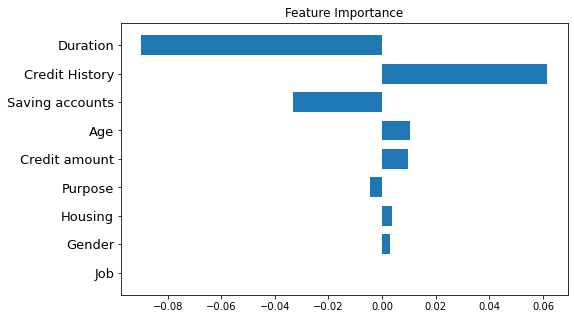

In [70]:
fig = plt.figure(figsize=(8,5))
y_pos = np.arange(len(top_feature_names))

values = np.flip(top_shape_vals)
features = np.flip(top_feature_names)

plt.barh(y_pos, values, 0.7, align='center')
plt.yticks(y_pos, fontsize=13)
plt.gca().set_yticklabels(features)
plt.title("Feature Importance")